# Comparison of different MPI calibrations made on grvingt

Two kinds of deployment:
- no deployment,
- deployment with the `base` image.

Two versions of OpenMPI:
- 2.0.2,
- 3.1.1.

Three different calibrations (I did not try OpenMPI 3.1.1 with no deployment).

In [1]:
import os
import numpy
import pandas
from extract_archive import extract_zip, aggregate_dataframe
archive_names = [f for f in os.listdir() if f.endswith('.zip') and f.startswith('nancy')]
alldf = []
aggr = []
for name in archive_names:
    archive = extract_zip(name)
    df = archive['exp/exp_Recv.csv']
    df['batch_index'] = numpy.floor(df.index / 10).astype(int)
    df['batch_index_mod'] = df.batch_index % 50 # 50 batches of 10 calls
    info = archive['info.yaml']
    deployment = str(info['deployment'])
    df['deployment'] = deployment
    mpi_version = set([info[key]['mpi'] for key in info.keys() if 'grid5000' in key])
    assert len(mpi_version) == 1
    mpi_version = mpi_version.pop()
    df['mpi'] = mpi_version
    df['exp_type'] = mpi_version + ' | ' + deployment
    alldf.append(df)
    aggr.append(aggregate_dataframe(df))
df = pandas.concat(alldf)
df_aggr = pandas.concat(aggr)
print(df.type.unique())
df.head()

['exp/exp_Recv.csv']


,op,msg_size,start,duration,experiment,type,deployment,index,batch_index,batch_index_mod,mpi,exp_type
0,MPI_Recv,765921,0.001925,0.000080,nancy,exp/exp_Recv.csv,debian9-x64-base,0,0,0,mpirun (Open MPI) 3.1.1,mpirun (Open MPI) 3.1.1 | debian9-x64-base
1,MPI_Recv,765921,0.002815,0.000073,nancy,exp/exp_Recv.csv,debian9-x64-base,1,0,0,mpirun (Open MPI) 3.1.1,mpirun (Open MPI) 3.1.1 | debian9-x64-base
2,MPI_Recv,765921,0.003654,0.000073,nancy,exp/exp_Recv.csv,debian9-x64-base,2,0,0,mpirun (Open MPI) 3.1.1,mpirun (Open MPI) 3.1.1 | debian9-x64-base
3,MPI_Recv,765921,0.004494,0.000072,nancy,exp/exp_Recv.csv,debian9-x64-base,3,0,0,mpirun (Open MPI) 3.1.1,mpirun (Open MPI) 3.1.1 | debian9-x64-base
4,MPI_Recv,765921,0.005333,0.000072,nancy,exp/exp_Recv.csv,debian9-x64-base,4,0,0,mpirun (Open MPI) 3.1.1,mpirun (Open MPI) 3.1.1 | debian9-x64-base


In [2]:
%matplotlib inline
from plotnine import *
import plotnine; plotnine.options.figure_size = 12, 8
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

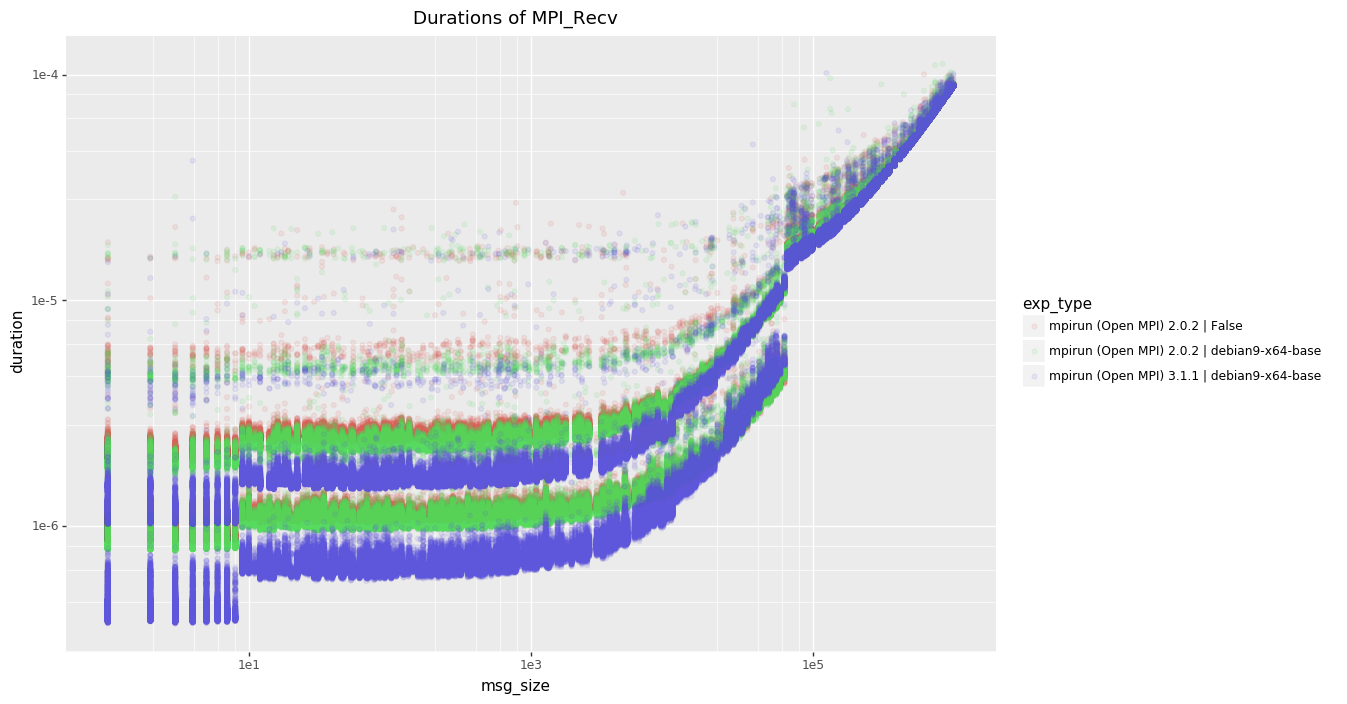

<ggplot: (-9223363256974436194)>

In [3]:
ggplot(df, aes(x='msg_size', y='duration', color='exp_type')) + geom_point(alpha=0.1) + scale_x_log10() + scale_y_log10() + ggtitle('Durations of MPI_Recv')

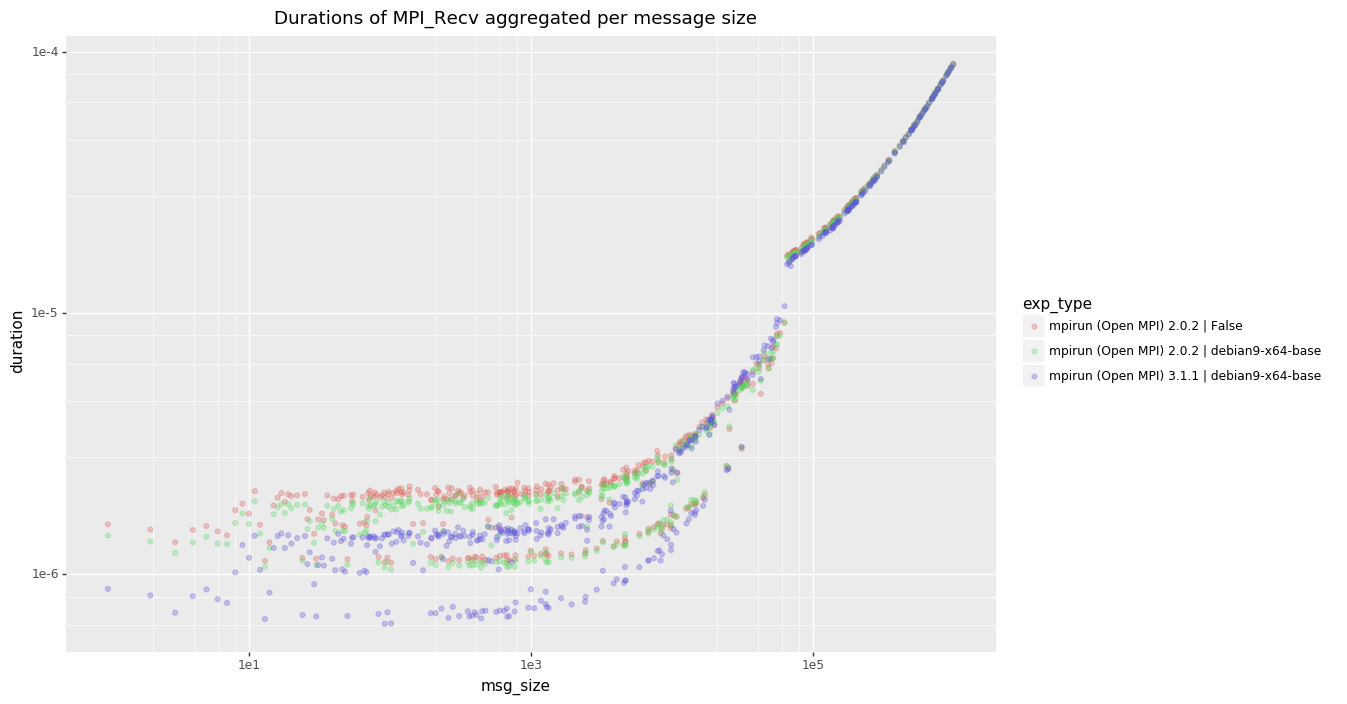

<ggplot: (-9223363256979984331)>

In [4]:
ggplot(df_aggr, aes(x='msg_size', y='duration', color='exp_type')) + geom_point(alpha=0.3) + scale_x_log10() + scale_y_log10() + ggtitle('Durations of MPI_Recv aggregated per message size')

We clearly see that the aggregated plot remains bimodal when aggregated per message size.

## Restricting ourselves to three message sizes

4500
4455


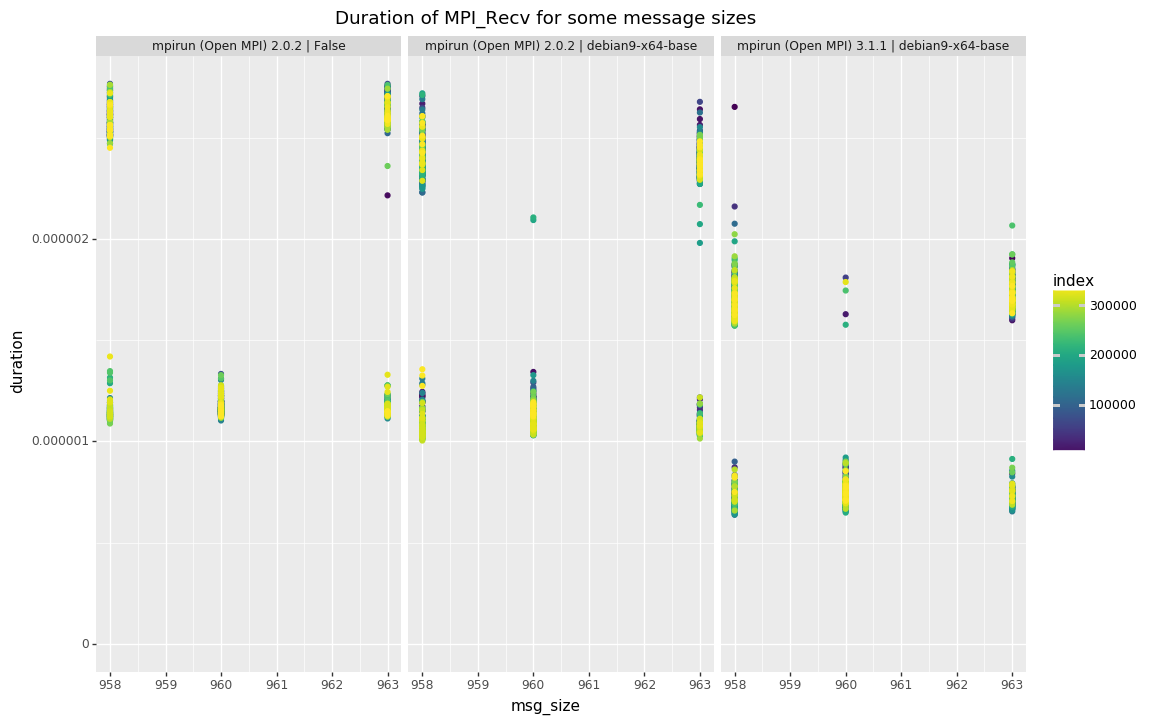

<ggplot: (8779861314410)>

In [5]:
tmp = df[(df.msg_size >= 950) & (df.msg_size < 970)]
print(len(tmp))
tmp = tmp[(tmp.duration < tmp.duration.quantile(0.99))] # removing the obvious outliers...
print(len(tmp))

ggplot(tmp, aes(x='msg_size', y='duration', color='index')) + geom_point() + expand_limits(y=0) + ggtitle('Duration of MPI_Recv for some message sizes') +\
    facet_wrap('exp_type')

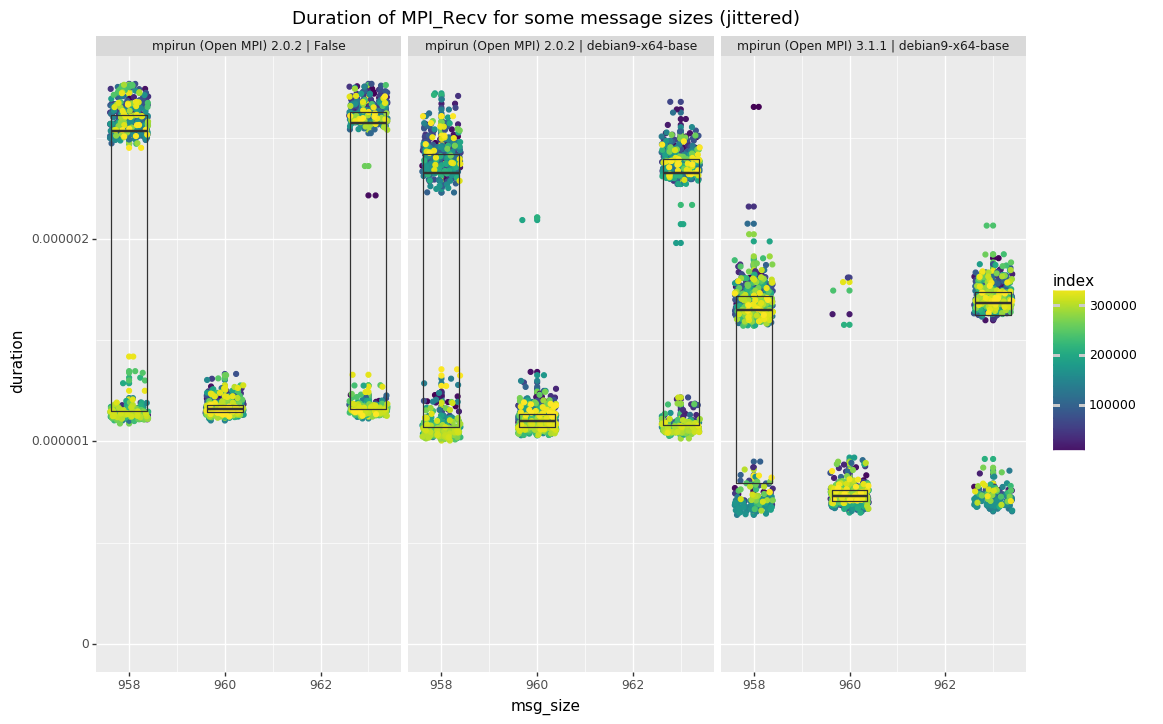

<ggplot: (-9223363256980346154)>

In [6]:
ggplot(tmp, aes(x='msg_size', y='duration', color='index')) + geom_point() + geom_jitter() + expand_limits(y=0) +\
    ggtitle('Duration of MPI_Recv for some message sizes (jittered)') +\
    geom_boxplot(group='msg_size', alpha=0) + facet_wrap('exp_type')

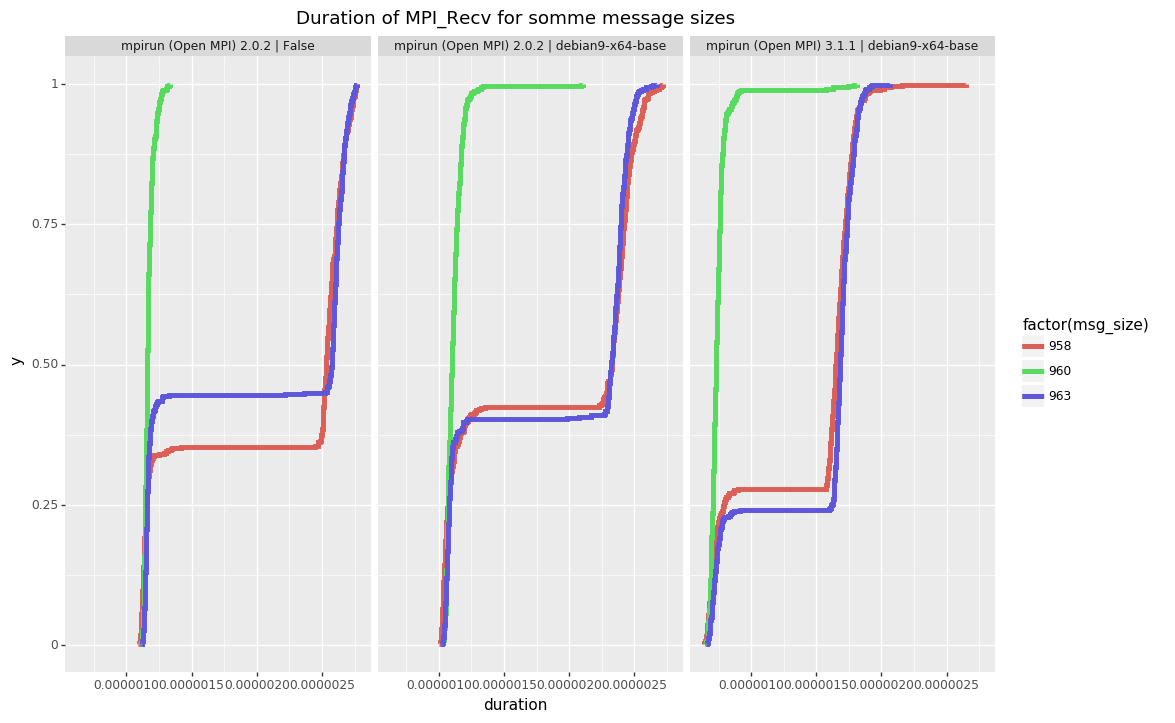

<ggplot: (-9223363256975517191)>

In [7]:
min_d = tmp.duration.min()
max_d = tmp.duration.max()
ggplot(tmp, aes('duration', color='factor(msg_size)')) + stat_ecdf(size=2) + expand_limits(x=min_d) + expand_limits(x=max_d) +\
        ggtitle('Duration of MPI_Recv for somme message sizes') + facet_wrap('exp_type', scales='free_x')

In [8]:
import pandas
pandas.set_option('display.float_format', lambda x: '%.2e' % x)
tmp[['msg_size', 'duration', 'exp_type']].groupby(['msg_size', 'exp_type']).describe()

duration           \
                                                       count     mean   
msg_size exp_type                                                       
958      mpirun (Open MPI) 2.0.2 | False            4.81e+02 2.08e-06   
         mpirun (Open MPI) 2.0.2 | debian9-x64-base 4.95e+02 1.85e-06   
         mpirun (Open MPI) 3.1.1 | debian9-x64-base 4.97e+02 1.43e-06   
960      mpirun (Open MPI) 2.0.2 | False            5.00e+02 1.17e-06   
         mpirun (Open MPI) 2.0.2 | debian9-x64-base 4.99e+02 1.11e-06   
         mpirun (Open MPI) 3.1.1 | debian9-x64-base 5.00e+02 7.45e-07   
963      mpirun (Open MPI) 2.0.2 | False            4.89e+02 1.97e-06   
         mpirun (Open MPI) 2.0.2 | debian9-x64-base 4.96e+02 1.86e-06   
         mpirun (Open MPI) 3.1.1 | debian9-x64-base 4.98e+02 1.48e-06   

                                                                       \
                                                         std      min   
msg_size exp_type                                                       
958      mpirun (Open MPI) 2.0.2 | False            6.97e-07 1.09e-06   
         mpirun (Open MPI) 2.0.2 | debian9-x64-base 6.66e-07 1.00e-06   
         mpirun (Open MPI) 3.1.1 | debian9-x64-base 4.50e-07 6.37e-07   
960      mpirun (Open MPI) 2.0.2 | False            3.46e-08 1.10e-06   
         mpirun (Open MPI) 2.0.2 | debian9-x64-base 8.02e-08 1.03e-06   
         mpirun (Open MPI) 3.1.1 | debian9-x64-base 1.07e-07 6.48e-07   
963      mpirun (Open MPI) 2.0.2 | False            7.31e-07 1.11e-06   
         mpirun (Open MPI) 2.0.2 | debian9-x64-base 6.46e-07 1.01e-06   
         mpirun (Open MPI) 3.1.1 | debian9-x64-base 4.28e-07 6.54e-07   

                                                                       \
                                                         25%      50%   
msg_size exp_type                                                       
958      mpirun (Open MPI) 2.0.2 | False            1.15e-06 2.53e-06   
         mpirun (Open MPI) 2.0.2 | debian9-x64-base 1.07e-06 2.33e-06   
         mpirun (Open MPI) 3.1.1 | debian9-x64-base 7.92e-07 1.65e-06   
960      mpirun (Open MPI) 2.0.2 | False            1.14e-06 1.16e-06   
         mpirun (Open MPI) 2.0.2 | debian9-x64-base 1.07e-06 1.10e-06   
         mpirun (Open MPI) 3.1.1 | debian9-x64-base 7.06e-07 7.31e-07   
963      mpirun (Open MPI) 2.0.2 | False            1.16e-06 2.57e-06   
         mpirun (Open MPI) 2.0.2 | debian9-x64-base 1.08e-06 2.32e-06   
         mpirun (Open MPI) 3.1.1 | debian9-x64-base 1.62e-06 1.68e-06   

                                                                       
                                                         75%      max  
msg_size exp_type                                                      
958      mpirun (Open MPI) 2.0.2 | False            2.61e-06 2.77e-06  
         mpirun (Open MPI) 2.0.2 | debian9-x64-base 2.42e-06 2.72e-06  
         mpirun (Open MPI) 3.1.1 | debian9-x64-base 1.72e-06 2.65e-06  
960      mpirun (Open MPI) 2.0.2 | False            1.18e-06 1.33e-06  
         mpirun (Open MPI) 2.0.2 | debian9-x64-base 1.14e-06 2.11e-06  
         mpirun (Open MPI) 3.1.1 | debian9-x64-base 7.58e-07 1.81e-06  
963      mpirun (Open MPI) 2.0.2 | False            2.63e-06 2.77e-06  
         mpirun (Open MPI) 2.0.2 | debian9-x64-base 2.39e-06 2.68e-06  
         mpirun (Open MPI) 3.1.1 | debian9-x64-base 1.74e-06 2.07e-06

For the three calibrations, the `MPI_Recv` with message size of 960 have a duration with a low mean, a low variance and a single mode, whereas the `MPI_Recv` with message sizes of 958 and 963 have a much higher mean and variances and have two modes.

## Temporal pattern

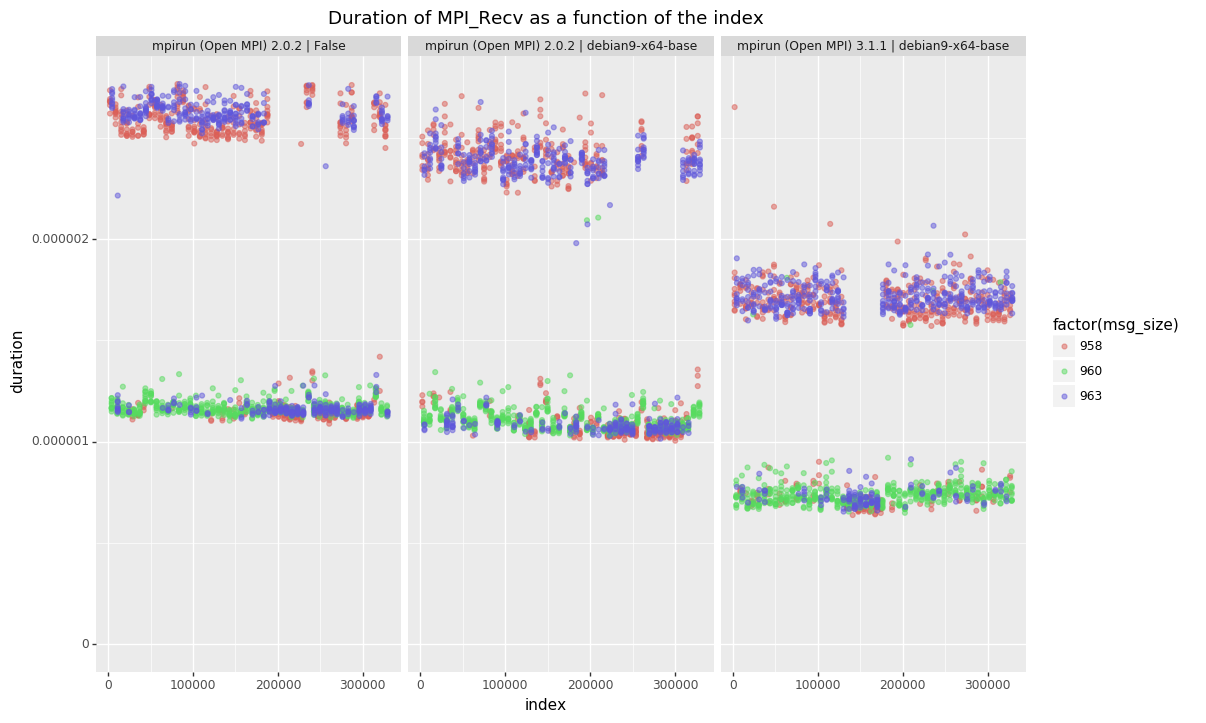

<ggplot: (-9223363256993461616)>

In [9]:
ggplot(tmp, aes(x='index', y='duration', color='factor(msg_size)')) + geom_point(alpha=0.5) + expand_limits(y=0) +\
    ggtitle('Duration of MPI_Recv as a function of the index') + facet_wrap('exp_type')

There is a very clear temporal pattern: at some points in time, the `MPI_Recv` with message sizes of 958 and 963 are much longer. This does not happen for messages of size 960. This happens for our three calibrations.

## Distribution within each batch

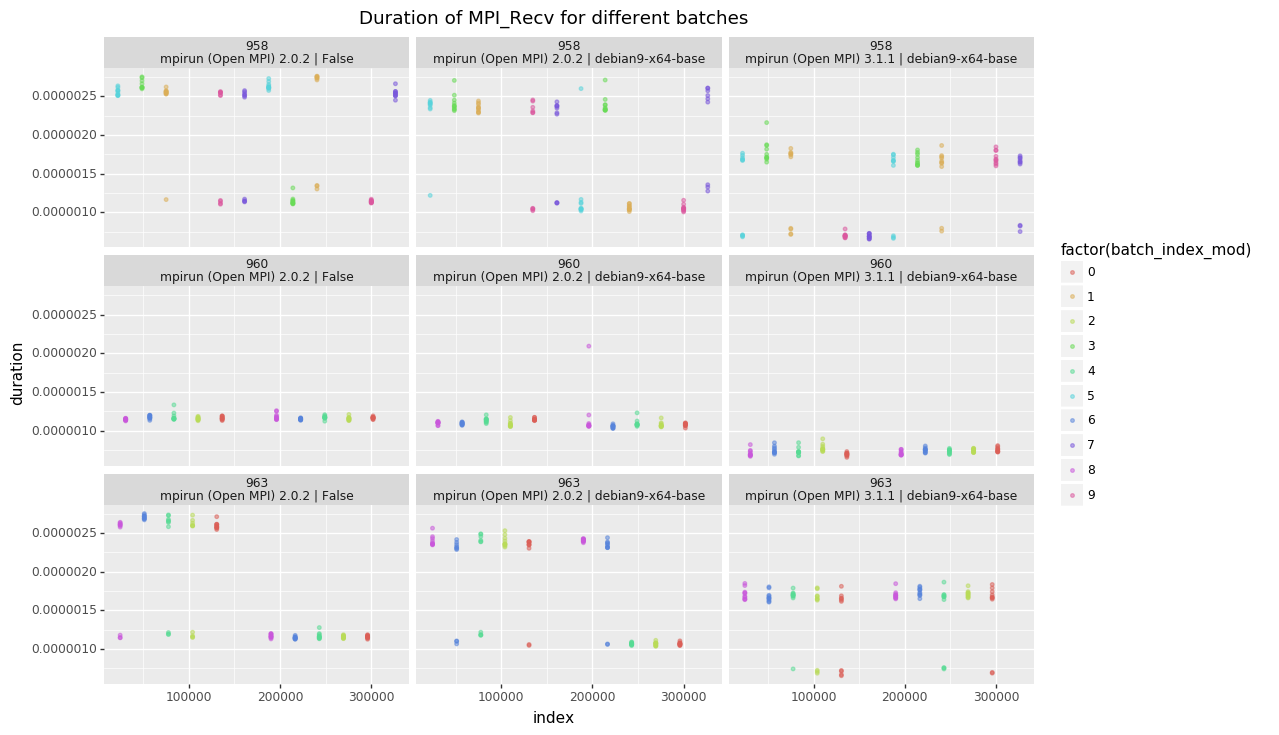

<ggplot: (-9223363256975758062)>

In [10]:
i = 0
ggplot(tmp[(tmp.batch_index_mod >= i) & (tmp.batch_index_mod < i+10)], aes(x='index', y='duration', color='factor(batch_index_mod)')) + geom_point(size=1, alpha=0.5) +\
    ggtitle('Duration of MPI_Recv for different batches') + facet_wrap(['msg_size', 'exp_type'])

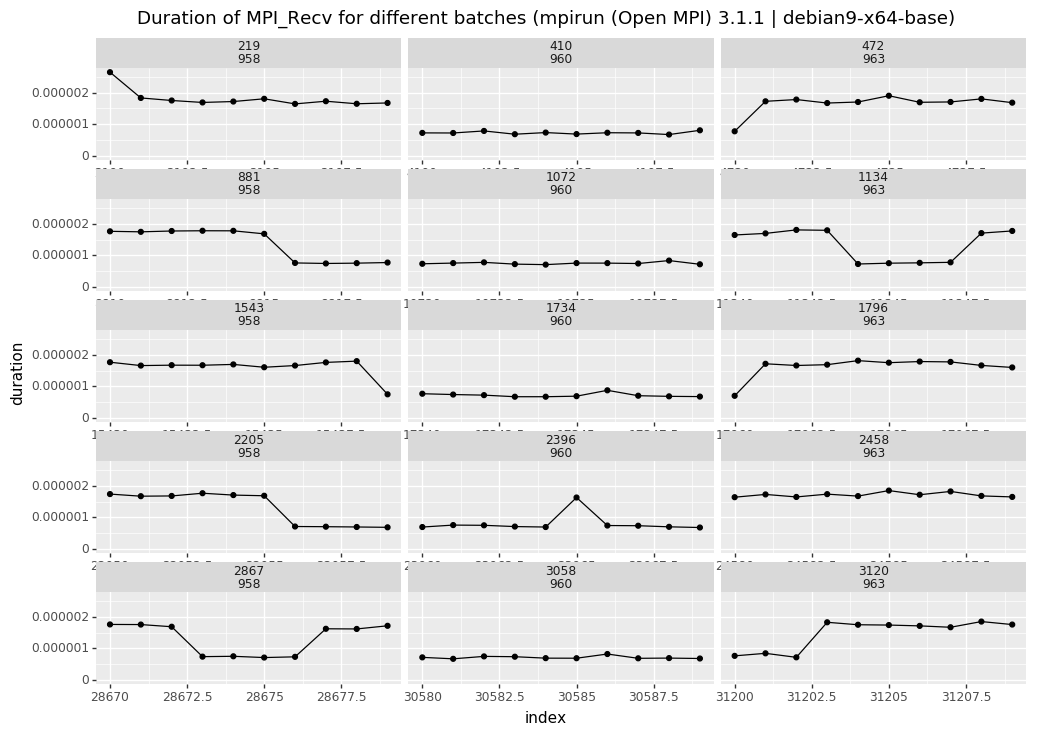

<ggplot: (8779860821575)>


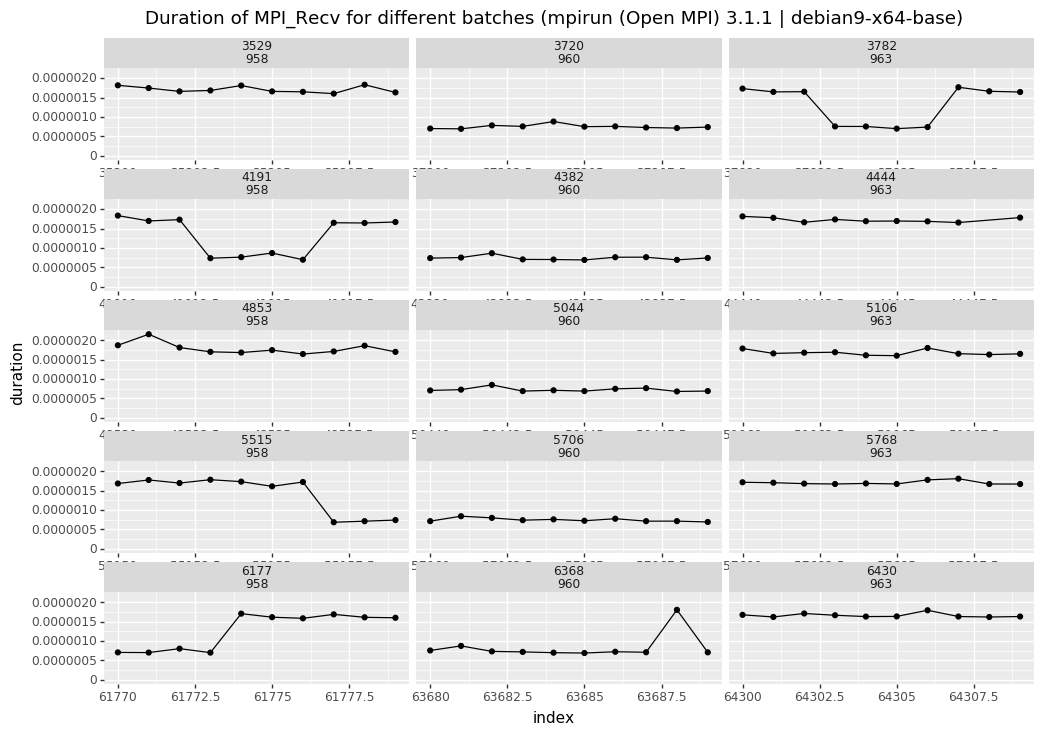

<ggplot: (8779878627592)>


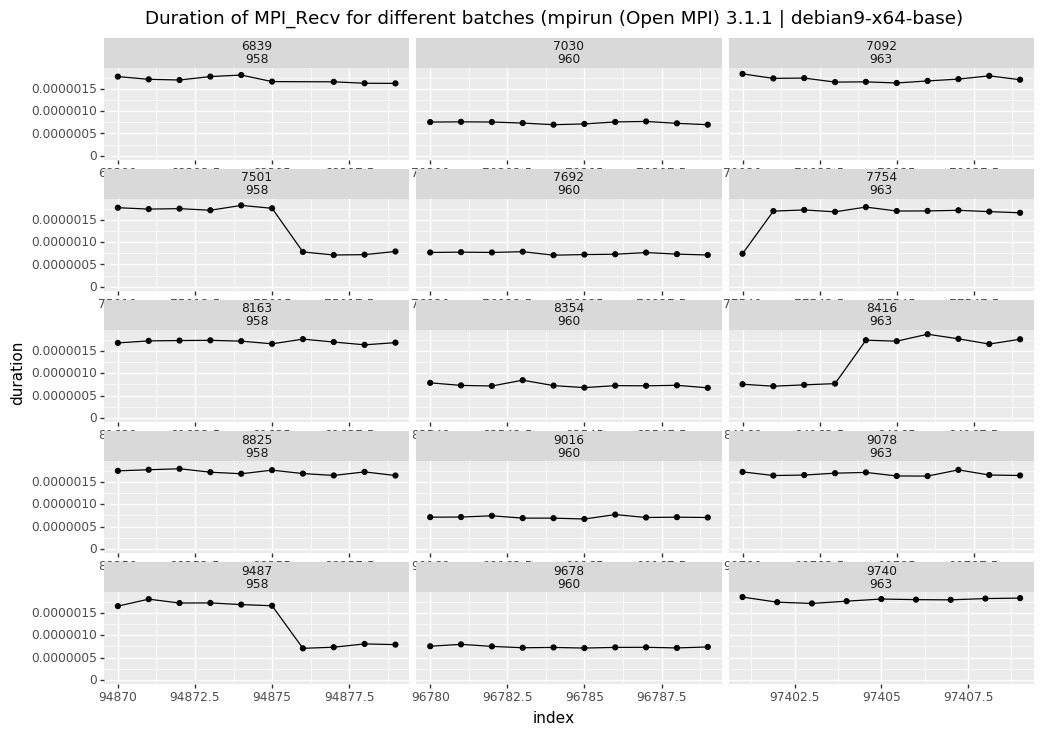

<ggplot: (8779879096040)>


In [11]:
def plot_exp(exp_id):
    exp = tmp.exp_type.unique()[exp_id]
    tmp_exp = tmp[tmp.exp_type == exp]
    indices = list(tmp_exp.batch_index.unique())
    for i in [0, 15, 30]:
        print(ggplot(tmp_exp[tmp_exp.batch_index.isin(indices[i:i+15])], aes(x='index', y='duration')) + geom_point() + geom_line() + expand_limits(y=0) +\
             ggtitle('Duration of MPI_Recv for different batches (%s)' % exp) + facet_wrap(['batch_index', 'msg_size'], ncol=3, scales='free_x'))
plot_exp(0)

It seems that the bimodality rather happens **within** the batches and not between two different batches.

For message sizes 958 and 963, roughly one third of the batches are clearly bimodal. The batches that have a single mode are roughly in the same spot.
For message size 960, I did not see any clear bimodality, but some of the batches have more variability than others.

In bimodal batches, the bimodality seems to be caused by some temporal factor.